# **A. Préparation: bibliothèques, données, preprocessing**

## 1. Importation des bibliothèques nécessaires.

In [52]:
import numpy as np
import pandas as pd
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")
from preprocessing import preprocess_data
from outils import save_to_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

## 2. Importation des données

In [2]:
dataset_train = pd.read_csv("../data/x_train.csv") #contient les features et le label
dataset_test = pd.read_csv("../data/x_test.csv") #contient uniquement les features
y_test = pd.read_csv("../data/y_test.csv") #contient uniquement le label

## 3. Définition des labels

Cette cellule définit deux dictionnaires pour mapper les catégories de niveaux d'eau des nappes phréatiques entre leur représentation en entiers (utilisée pour le traitement numérique) et leur représentation en chaînes de caractères (plus compréhensible pour les humains).

In [3]:
mapping_int_to_string = {
    0: 'Average',
    1: 'High',
    2: 'Low',
    3: 'Very High',
    4: 'Very Low'
}
mapping_string_to_int = {value: key for key, value in mapping_int_to_string.items()}

## 4.Séparation, transformation et prétraitement des données d'entraînement et de test.

### Description des variables:

Données d'entraînement (features et labels) :
- X_train : Features uniquement.
- y_train : Labels (catégories sous forme entière).
- row_index_train : Identifiants des lignes.

Données de test :
- X_test : Features uniquement.
- row_index_test : Identifiants des lignes.

Données combinées :
- all_features : Fusion des features des deux jeux (train + test).

Données prétraitées :
- preprocessed_features_all : Données prétraitées combinées.
- X_train_preprocessed : Partie entraînement des données prétraitées.
- X_test_preprocessed : Partie test des données prétraitées.

In [4]:
# Séparation des caractéristiques, des labels, et des indices pour le jeu d'entraînement
X_train, y_train, row_index_train = dataset_train.drop(columns=["piezo_groundwater_level_category","row_index"]), dataset_train["piezo_groundwater_level_category"].map(mapping_string_to_int), dataset_train["row_index"]

In [6]:
# Séparation des caractéristiques, des labels et des indices pour le jeu de test
X_test, row_index_test = dataset_test.drop(columns=["row_index"]), dataset_test["row_index"]
y_test = y_test["piezo_groundwater_level_category"].map(mapping_string_to_int)

In [8]:
# Fusion des caractéristiques des jeux d'entraînement et de test pour prétraitement uniforme
all_features = pd.concat([X_train, X_test], axis=0)

# Prétraitement des données combinées
preprocessed_features_all = preprocess_data(all_features)

# Division des données prétraitées en entraînement et test
X_train_preprocessed = preprocessed_features_all[:len(X_train)]
X_test_preprocessed = preprocessed_features_all[len(X_train):]

Columns with mixed types: ['piezo_station_department_code', 'piezo_station_commune_code_insee', 'piezo_measure_nature_code', 'prelev_structure_code_0', 'prelev_usage_label_0', 'prelev_volume_obtention_mode_label_0', 'prelev_structure_code_1', 'prelev_usage_label_1', 'prelev_volume_obtention_mode_label_1', 'prelev_structure_code_2', 'prelev_usage_label_2', 'prelev_volume_obtention_mode_label_2']
No missing values in the dataset


A présent, on vérifie si le jeu de données combiné (preprocessed_features_all) contient des valeurs manquantes (NaN) et, si c’est le cas, identifie et affiche les colonnes concernées ainsi que leurs premières lignes avec des valeurs manquantes.

In [9]:
if preprocessed_features_all.isna().sum().sum() > 0:
    # Identifier les colonnes avec des valeurs manquantes
    cols_with_na = preprocessed_features_all.columns[preprocessed_features_all.isna().any()].tolist()
    print(f"Columns with missing values: {cols_with_na}")
    
    # Afficher les premières lignes des colonnes concernées
    print(preprocessed_features_all[cols_with_na].head())
else:
    print("No missing values in the dataset")

No missing values in the dataset


# **B. Modèle baseline**

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
X_train_preprocessed.head()

,piezo_station_update_date,piezo_station_investigation_depth,piezo_station_altitude,piezo_station_longitude,piezo_station_latitude,piezo_station_bss_id,piezo_bss_code,piezo_measurement_date,piezo_continuity_code,piezo_producer_code,...,piezo_status_Donnée contrôlée niveau 1,piezo_status_Donnée contrôlée niveau 2,piezo_status_Donnée interprétée,piezo_qualification_Incertaine,piezo_qualification_Incorrecte,piezo_qualification_Non qualifié,piezo_continuity_name_Point lié au point précédent,hydro_qualification_label_Douteuse,hydro_qualification_label_Non qualifiée,hydro_hydro_quantity_elab_QmM
0,226.0,0.003822,0.390918,0.733960,0.462674,1561.0,1563.0,2020-01-01,1.0,2.900484e-12,...,False,True,False,False,False,False,True,False,False,False
1,226.0,0.006802,0.395761,0.706338,0.483565,1466.0,1468.0,2020-01-01,1.0,2.900484e-12,...,False,True,False,False,False,False,True,False,False,True
2,226.0,0.006730,0.386716,0.696756,0.469735,1557.0,1559.0,2020-01-01,1.0,2.900484e-12,...,False,True,False,False,False,False,True,False,False,False
3,226.0,0.006535,0.475977,0.748120,0.501648,1417.0,1419.0,2020-01-01,1.0,2.900484e-12,...,False,True,False,False,False,False,True,True,False,True
4,226.0,0.007127,0.399809,0.703285,0.494880,1416.0,1418.0,2020-01-01,1.0,2.900484e-12,...,False,True,False,False,False,False,True,False,False,False


In [12]:
# Vérification des types de données
pd.set_option('display.max_rows', None)
print(preprocessed_features_all.dtypes)

# Conversion des colonnes datetime
datetime_cols = preprocessed_features_all.select_dtypes(include=['datetime64']).columns
for col in datetime_cols:
    preprocessed_features_all[col] = preprocessed_features_all[col].astype('int64')  # Conversion en timestamp

# Conversion des colonnes booléennes
bool_cols = preprocessed_features_all.select_dtypes(include=['bool']).columns
preprocessed_features_all[bool_cols] = preprocessed_features_all[bool_cols].astype('int')

# Vérification des types après conversion
print(preprocessed_features_all.dtypes)

# Repartir les données entre entraînement et test
X_train_preprocessed = preprocessed_features_all[:len(X_train)]
X_test_preprocessed = preprocessed_features_all[len(X_train):]

piezo_station_update_date                                    float64
piezo_station_investigation_depth                            float64
piezo_station_altitude                                       float64
piezo_station_longitude                                      float64
piezo_station_latitude                                       float64
piezo_station_bss_id                                         float64
piezo_bss_code                                               float64
piezo_measurement_date                                datetime64[ns]
piezo_continuity_code                                        float64
piezo_producer_code                                          float64
meteo_id                                                     float64
meteo_altitude                                               float64
meteo_date                                                   float64
meteo_rain_height                                            float64
meteo_DRR                         

In [13]:
print(len(X_train_preprocessed))
print(len(y_train))

2830316
2830316


In [14]:
model_baseline = DecisionTreeClassifier(random_state=42)
model_baseline.fit(X_train_preprocessed, y_train)

DecisionTreeClassifier(random_state=42)

In [71]:
# Effectuer les prédictions sur les données de test
y_pred = model_baseline.predict(X_test_preprocessed)

# Afficher les résultats des prédictions
print(y_pred)

[0 4 4 ... 2 1 0]


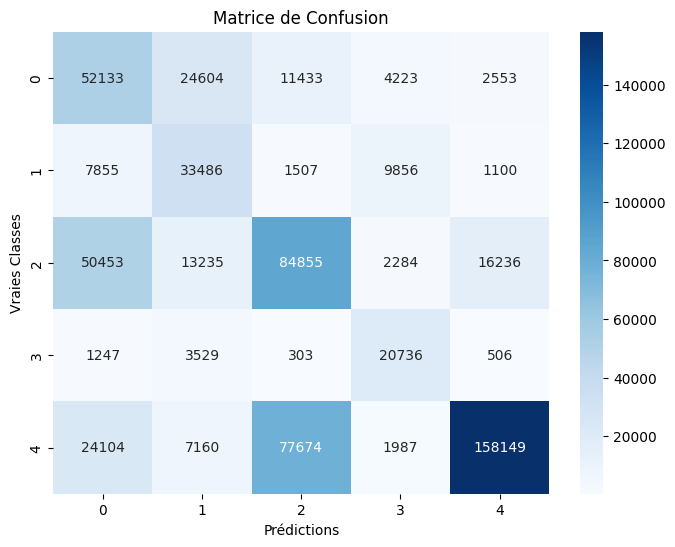

In [72]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Tracer la matrice de confusion
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion")
plt.show()

C'est déjà très très bien !

# **C. Modèle LSTM**

Il y a trop de features, ça prend trop de puissance de calcul.
On réduit donc X_train_preprocessed à quelques features.
Le nouveau dataframe s'appelle X_train_for_NN.

In [15]:
# Sélection des variables pertinentes
FEATURES = [
    'piezo_station_investigation_depth', 
    'meteo_rain_height', 
    'prelev_volume_1',
    'prelev_volume_2',
    'prelev_other_volume_sum',
]

X_train_for_NN = X_train_preprocessed[FEATURES].dropna()
X_test_for_NN = X_test_preprocessed[FEATURES].dropna()

In [16]:
# Création des séquences pour le LSTM
def create_sequences(data, target, sequence_length=30):
    """
    Génère des séquences temporelles pour entraîner un modèle LSTM.
    
    Paramètres :
    - data : DataFrame contenant les features.
    - target : DataFrame contenant le label.
    - sequence_length : int, longueur de la fenêtre de temps utilisée pour créer chaque séquence (par défaut 30).

    Retourne :
    - X : numpy array, tableau contenant les séquences de longueur `sequence_length`.
    - y : numpy array, tableau contenant les valeurs cibles associées à chaque séquence.
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])  # Séquence de longueur `sequence_length`
        y.append(target.iloc[i+sequence_length])  # Utilisation de .iloc pour récupérer la valeur à la position i+sequence_length
    return np.array(X), np.array(y)  # Conversion en arrays numpy (indispensable pour LSTM)

In [17]:
X_train_seq_LSTM, y_train_seq_LSTM = create_sequences(X_train_for_NN, y_train, sequence_length=30)

In [18]:
X_test_seq_LSTM, y_test_seq_LSTM = create_sequences(X_test_for_NN, y_test, sequence_length=30)

In [33]:
# Construction du modèle LSTM
model_LSTM = Sequential([
    LSTM(50, return_sequences=True, input_shape=(30, len(FEATURES))),  # sequence_length=30
    Dropout(0.2),  # Evite l'overfitting
    LSTM(50, return_sequences=False),
    Dropout(0.2),  # Evite l'overfitting
    Dense(25, activation='relu'),  # Première couche fully connected
    Dense(5, activation='softmax')  # Couche de sortie - Prédiction multi-classes avec 5 classes
])

# Compilation du modèle
model_LSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [34]:
# Convertir X et y en float32
X_train_seq_LSTM = X_train_seq_LSTM.astype('float32')
y_train_seq_LSTM = y_train_seq_LSTM.astype('float32')
X_test_seq_LSTM = X_test_seq_LSTM.astype('float32')
y_test_seq_LSTM = y_test_seq_LSTM.astype('float32')

D'après nos entrainements précédents, 3 epochs semblaient suffisants.

In [35]:
# Définition du callback pour sauvegarder les poids
checkpoint_callback = ModelCheckpoint(
    "best_model.h5",  # Nom du fichier de sauvegarde
    monitor="val_loss",  # Surveiller la validation loss
    save_best_only=True,  # Sauvegarder uniquement le meilleur modèle
    save_weights_only=True,  # Sauvegarder uniquement les poids (pas l'architecture)
    mode="min",  # Sauvegarde si val_loss diminue
    verbose=1
)

# Entraînement du modèle
model_LSTM.fit(
    X_train_seq_LSTM, 
    y_train_seq_LSTM, 
    epochs=3, 
    batch_size=32, 
    validation_data=(X_test_seq_LSTM, y_test_seq_LSTM))

Epoch 1/3
88447/88447 [==============================] - 740s 8ms/step - loss: 1.5506 - accuracy: 0.2728 - val_loss: 1.5588 - val_accuracy: 0.2874
Epoch 2/3
88447/88447 [==============================] - 750s 8ms/step - loss: 1.4688 - accuracy: 0.3341 - val_loss: 1.5408 - val_accuracy: 0.3107
Epoch 3/3
88447/88447 [==============================] - 763s 9ms/step - loss: 1.4292 - accuracy: 0.3579 - val_loss: 1.5166 - val_accuracy: 0.3236


In [36]:
model_LSTM.save_weights("model_LSTM_weights.h5")

In [ ]:
# #En cas de problème, recharger les poids ici:
# Recréer le modèle avec la même architecture
# Charger les poids sauvegardés avec:
# model_LSTM.load_weights("model_LSTM_weights.h5")

#### Y a t il de l'underfitting ou de l'overfitting?

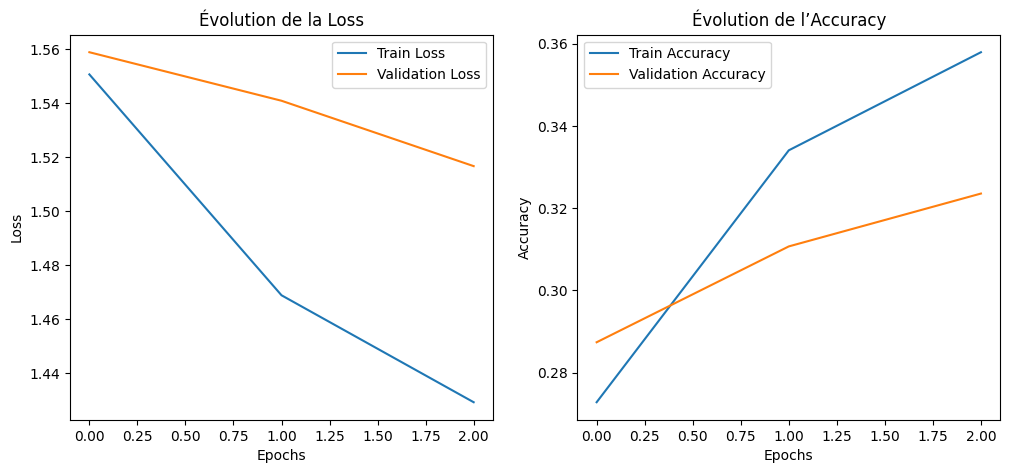

In [40]:
# Récupération de l'historique de l'entraînement
history = model_LSTM.history  # Stocke l'historique du modèle

# Tracer la loss (fonction de coût)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Évolution de la Loss')

# Tracer l'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Évolution de l’Accuracy')

plt.show()


#### f1_score du LSTM:

In [41]:
# Évaluation sur les données de test
train_loss, train_acc = model_LSTM.evaluate(X_train_seq_LSTM, y_train_seq_LSTM)
test_loss, test_acc = model_LSTM.evaluate(X_test_seq_LSTM, y_test_seq_LSTM)

print(f"Train Accuracy : {train_acc:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

19100/19100 [==============================] - 39s 2ms/step - loss: 1.5166 - accuracy: 0.3236
Train Accuracy : 0.3888
Test Accuracy : 0.3236


In [45]:
# Prédictions sur les données de test
y_pred_probs = model_LSTM.predict(X_test_seq_LSTM)  # Probabilités des classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convertir en classes

# Affichage du rapport de classification (F1-score, recall, precision)
print(classification_report(y_test_seq_LSTM, y_pred_classes))

19100/19100 [==============================] - 40s 2ms/step
              precision    recall  f1-score   support

         0.0       0.20      0.36      0.26     94939
         1.0       0.18      0.28      0.22     53802
         2.0       0.30      0.31      0.31    167051
         3.0       0.18      0.38      0.24     26317
         4.0       0.68      0.32      0.44    269069

    accuracy                           0.32    611178
   macro avg       0.31      0.33      0.29    611178
weighted avg       0.43      0.32      0.35    611178



#### Vu les résultats, il y a de l'underfitting. Nous allons donc continuer à entrainer le modèle:

In [46]:
# Continuer l'entraînement avec 3 epochs supplémentaires
history_additional = model_LSTM.fit(
    X_train_seq_LSTM, y_train_seq_LSTM,
    epochs=3,  # Ajout de 3 epochs
    batch_size=32,
    validation_data=(X_test_seq_LSTM, y_test_seq_LSTM)
)

Epoch 1/3
88447/88447 [==============================] - 783s 9ms/step - loss: 1.4066 - accuracy: 0.3719 - val_loss: 1.5269 - val_accuracy: 0.3286
Epoch 2/3
88447/88447 [==============================] - 760s 9ms/step - loss: 1.3923 - accuracy: 0.3807 - val_loss: 1.5117 - val_accuracy: 0.3302
Epoch 3/3
88447/88447 [==============================] - 773s 9ms/step - loss: 1.3817 - accuracy: 0.3868 - val_loss: 1.5261 - val_accuracy: 0.3206


In [47]:
model_LSTM.save_weights("model_LSTM_weights.h5")

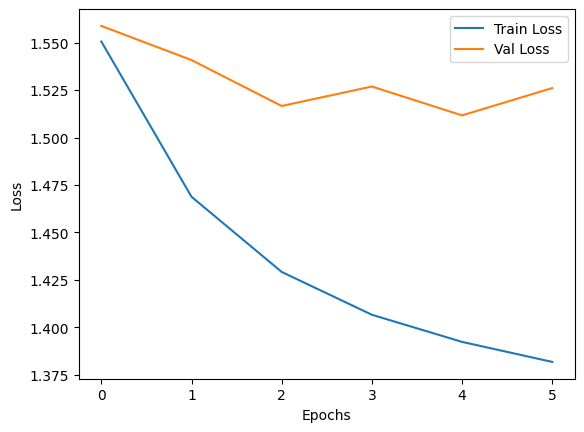

In [48]:
# Fusionner l'historique des pertes (loss)
plt.plot(history.history['loss'] + history_additional.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_additional.history['val_loss'], label='Val Loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

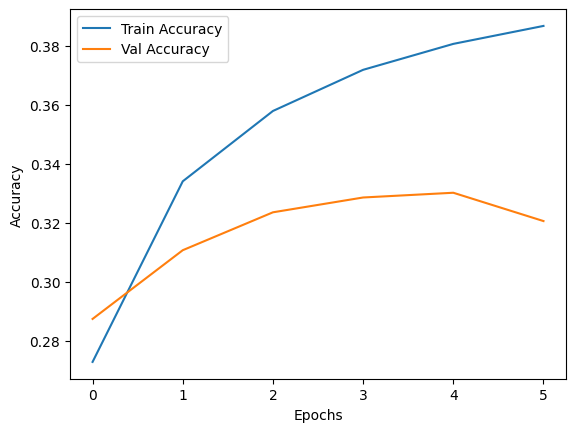

In [49]:
# Fusionner l'historique des accuracy
plt.plot(history.history['accuracy'] + history_additional.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_additional.history['val_accuracy'], label='Val Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Il y a de l'overfitting au dela de la 4eme epoch.

In [50]:
# Prédictions sur les données de test
y_pred_probs = model_LSTM.predict(X_test_seq_LSTM)  # Probabilités des classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convertir en classes

# Affichage du rapport de classification (F1-score, recall, precision)
print(classification_report(y_test_seq_LSTM, y_pred_classes))

19100/19100 [==============================] - 40s 2ms/step
              precision    recall  f1-score   support

         0.0       0.20      0.31      0.24     94939
         1.0       0.18      0.31      0.22     53802
         2.0       0.30      0.31      0.30    167051
         3.0       0.17      0.45      0.24     26317
         4.0       0.68      0.32      0.44    269069

    accuracy                           0.32    611178
   macro avg       0.30      0.34      0.29    611178
weighted avg       0.44      0.32      0.34    611178



#### Traçons la matrice de confusion pour évaluer la performance du modèle sur nos 5 classes.

In [ ]:
y_pred_proba = model_LSTM.predict(X_test_seq_LSTM)

In [67]:
y_pred = np.argmax(y_pred_proba, axis=1)

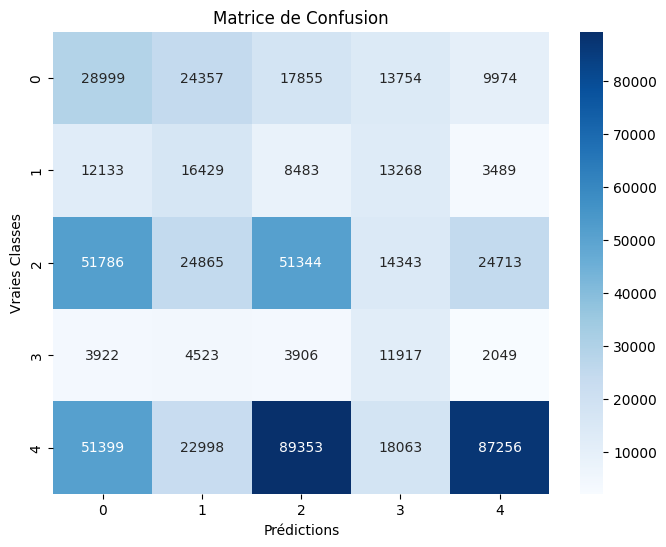

In [70]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test_seq_LSTM, y_pred)

# Tracer la matrice de confusion
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion")
plt.show()

Conclusion: on a des résultats mitigés sur ce LSTM, avec de grosses confusions. On ne s'attendait pas à beaucoup mieux étant donné qu'on a du restreindre notre étude à quelques colonnes à cause de notre puissance de calcul limitée. 